In [3]:
import pandas as pd
import io
from math import sqrt
import matplotlib.pyplot as plt 
import numpy as np
from datetime import datetime
from scipy import stats
import math
# scikit-learn bootstrap
from sklearn.utils import resample
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import seaborn as sns
from decimal import Decimal
import timeit

## Setting defaults for plots
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 400
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 'medium'
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20

In [4]:
#Important functions

def generate_random_weights(num):
    return np.random.exponential(1, num)

# R is the term in poisson likelihood function. check our paper for more details
def R(x,w): 
    s = 0;  # To store the required sum 
    n = len(x)
    for i in range(0,n): 
        # Add factorial of all the elements 
        s += math.lgamma(x[i]+1) * w[i]; #lgamma replaces the factorial term in poisson pdf
    return s

#Likelihood of poisson distribution
def Likelihood(theta,x,w = None):
    if w is None:
         w = np.ones(len(x))
    S = np.sum(x*w)
    n = np.sum(w) #n if weights equal 1, sum otherwise
    theta = theta+0.00000000001 # adding a very small number to avoid the problem of theta=0
    L = math.log(theta) * S - n *theta #- R(x,w)  #Here R can be commented out because it doesn't play a role in MLE calculation
    return L

def MLE_estimator(x, w = None):
    if w is None:
         w = np.ones(len(x))
    S = np.sum(x*w)
    n = np.sum(w)
    MLE = S/n
    return MLE

# For stepwise function plot
def mystep(x,y,z, ax=None, **kwargs):
    x = np.array(x)
    y = np.array(y)
    z = np.array(z)
    X = np.c_[x[:-1],x[1:],x[1:]]
    Y = np.c_[y[:-1],y[:-1],np.zeros_like(x[:-1])*np.nan]
    Z = np.c_[z[:-1],z[:-1],np.zeros_like(x[:-1])*np.nan]
    plt.figure(figsize=(15,8))
    if not ax: ax=plt.gca()
    ax.plot(X.flatten(), Z.flatten(), **kwargs)
    return ax.plot(X.flatten(), Y.flatten(), **kwargs)

# Vectorized poisson pdf calculator
def poisson(yi, theta):
    theta=theta + 0.0000000000001
    l = (theta**(yi)*math.exp(-theta)) #/math.factorial(yi) #Factorial term here is commented for the same reasons as R above
    return(math.log(l))

vpoisson = np.vectorize(poisson)

# These are the weights used in bootstrap procedure
def weights_matrix(num, length):
    weights = []
    for j in range(num):
        w = generate_random_weights(length) #weights for whole interval
        weights.append(w)
    weights= np.array(weights)
    return weights.T

# This is likelihood of poisson for each y
def likelihoods(y, theta):
    l=[]
    for i in range(len(theta)):
        loglikes= vpoisson(y,theta[i])
        l.append(loglikes)
    return np.array(l).T


#Simplifying numpy notation
def plus(a,b,c=0,d=0,e=0,h=0,i=0,j=0,k=0, l=0):
    sum_of_all = np.add(a,np.add(b,np.add(c,np.add(d,np.add(e,np.add(h,np.add(i,np.add(j,np.add(k,l)))))))))
    return sum_of_all

def neg(a):
    neg_a = np.multiply(a,-1)
    return neg_a

def product(a,b,c=1,d=1,e=1,h=1,i=1,j=1):
    product_of_all = np.multiply(a,np.multiply(b,np.multiply(c,np.multiply(d,np.multiply(e,np.multiply(h,np.multiply(i,j)))))))
    return product_of_all

def poisson(yi, theta):
    theta=theta + 0.0000000000001
    #l = (theta**(yi)*np.exp(-theta)) #/math.factorial(yi)
    l = float(Decimal(np.exp(-Decimal(theta))) * Decimal(theta)**Decimal(yi))#/math.factorial(Decimal(yi)))
    #l = stats.poisson.pmf(k=yi, mu=theta)
    return(np.log(l))

In [5]:
#Loading data. Change the name according to the required industry

dataset_name= 'cyclicalgoods_de'
#dataset_name= 'telecommunication_de'
#dataset_name= 'financials_de'
#dataset_name= 'energy_de'
DT_N = pd.read_csv('ma_'+dataset_name+'.csv', sep=',') 

DT_N.head()

,Date,N
0,1985-01-01,4
1,1985-02-01,0
2,1985-03-01,1
3,1985-04-01,1
4,1985-05-01,0


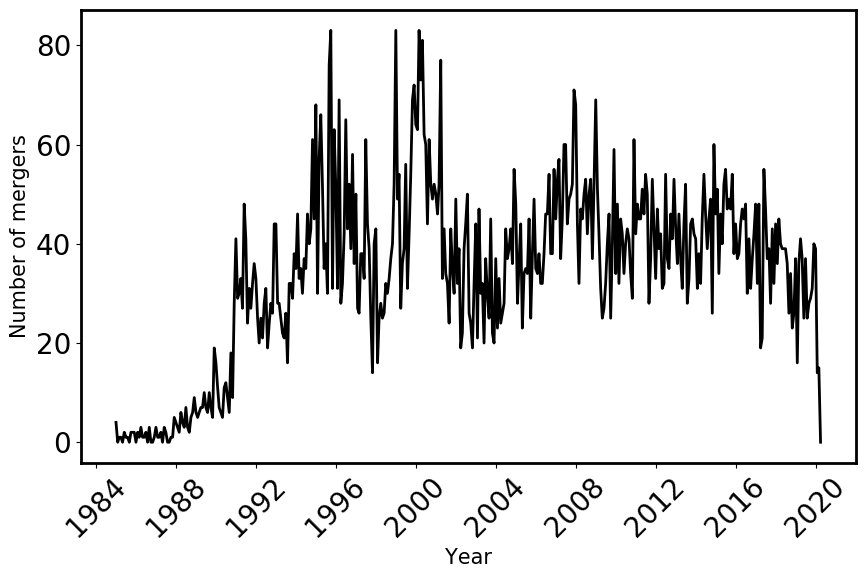

In [8]:
# Plotting the dataset

plt.figure()
dates = [pd.to_datetime(d) for d in DT_N.Date]
#DT_N.N.plot(label='Number of M&A',color = 'k' )
plt.plot(dates, DT_N.N, color = 'k')
plt.xlabel('Year')
plt.ylabel('Number of mergers')
plt.tick_params(axis="x", labelrotation = 45)
plt.savefig(dataset_name+'_data.png', transparent = True)
plt.show()

### Use this  code if you need to deal with missing data. running it once should be sufficient. Save the dataset and use that the next time

DT_N['Date'] =  pd.to_datetime(DT_N['Date'], format='%d.%m.%y')
###### Filling missing dates
DT_N = DT_N.set_index('Date').resample('MS').asfreq().fillna(0)
###### Saving this data as csv
DT_N.to_csv(r'MA_'+dataset_name+'.csv')

In [88]:
## Interval lengths and bounds
## Use this code to find out the interval lengths and boundries for your desired parameters. 
## There are two variants: Arithmetic and geomtric. In order to use one, the code lines linked to other one must be commented out

io = DT_N.shape[0] #starting from final time
c = 1.35 #from theory: it controls size of the intervals

n_0 = 5 #Assuming homogeneity in first three month

#Arithmetic increase
#K = int(io/n_0) #from theory

# Geometric increase
K = max(0,math.ceil((math.log(io)-math.log(n_0))/math.log(c))) #Calculated this analytically
print(K) # number of intervals

I_0 = list(DT_N.N[max(0,io-n_0):io])
n_k_minus1 = n_0 
I_k_minus1 = I_0
Interval_lengths=[]
Interval_endpoints=[]

for m in range(1,K+1): #started from 1 because 0th interval already homo and K+1 because last point is not inclusive
    # Geometric increase
    n_k = int(n_0 * c** m)
    n_k_minus1 = n_k
    
    #Arithmetic increase
    #n_k = (m+1)*n_0
    #n_k_plus1 = (m+2)*n_0
    
    I_k = list(DT_N.N[max(0,io-n_k):io])
    Interval_endpoints.append(max(0,io-n_k))
    Interval_lengths.append(len(I_k))
    J = list(range(max(0,io-n_k),io-n_k_minus1))
    I_k_minus1 = I_k
    n_k_minus1 = n_k
    
print(Interval_endpoints)
print(Interval_lengths)

424
20
[418, 417, 415, 412, 409, 405, 400, 394, 386, 377, 365, 350, 331, 307, 277, 240, 193, 135, 61, 0]
[6, 7, 9, 12, 15, 19, 24, 30, 38, 47, 59, 74, 93, 117, 147, 184, 231, 289, 363, 424]


In [95]:
## Main code

Data_N= np.array(DT_N.N) #changing data to numpy array because they are faster

# Initializing
start = timeit.default_timer()
io = Data_N.shape[0] #starting from final time
c = 1.35 #from theory
n_0 = 3 #Assuming homogeneity in first three month
K = max(0,math.ceil((math.log(io)-math.log(n_0))/math.log(c))) # number of intervals: calculated this analytically
I_0 = list(Data_N[max(0,io-n_0):io])
alpha = 0.95 #confidence level
num_sim = 100 #number of bootstraps that you want to do


n_k_minus1 = n_0 
I_k_minus1 = I_0

windows = []
MLEs = []
scaled_windows = []
tests=0
for l in range(0, Data_N.shape[0]):
    #starting at a new point for each iteration
    io = Data_N.shape[0]-l
    #Arithmetic increase
    #K = int(io/n_0) 

    # Geometric increase
    K = max(0,math.ceil((math.log(io)-math.log(n_0))/math.log(c))) #Calculated this analytically
    I_0 = list(Data_N[max(0,io-n_0):io])
    I_k_minus1 = I_0
    for k in range(1,K+1): 
        #started from 1 because 0th interval already homogeneous and K+1 because last point is not inclusive
            
       #Arithmetic
        #n_k = (k+1)*n_0
        #n_k_plus1 = (k+2)*n_0
        
        #Geometric increase
        n_k = int(n_0 * c** k)
        n_k_plus1 = int(n_0 * c** (k+1))
        I_k = list(Data_N[max(0,io-n_k):io])
        I_k_plus1 = list(Data_N[max(0,io-n_k_plus1):io])
        MLE_I_k_plus1 = MLE_estimator(I_k_plus1)
        len_I_k_plus1 = len(I_k_plus1)
        J = list(range(max(0,io-n_k),io-n_k_minus1))
        T = []
        T_b = []
        BS_dist = []
        
        # For each breakpoint that is in the set J, we calculate the test value and take max
        for i in J:
            #New intervals and their estimators
            A_k = np.array(Data_N[max(0,io-n_k_plus1):(i+1)])
            B_k = np.array(Data_N[i+1:io])
            MLE_A = MLE_estimator(A_k)
            MLE_B = MLE_estimator(B_k)
            
            # test statistics for this breakpoint and adding it to the list
            T_I_k = Likelihood(MLE_A, A_k) + Likelihood(MLE_B, B_k) - Likelihood(MLE_I_k_plus1, I_k_plus1)
            T.append(T_I_k)

            ## Bootstrap procedure
            #  Getting lengths of intervals
                
            len_A = len(A_k) #length of A_k
            len_B = len(B_k) #length of B_k
                
            #generating weights and calculating estimators for the bootstrap intervals

            weights_A = weights_matrix(num_sim,len_A)
            sum_A_w = np.matmul(A_k,weights_A) 
            sum_wA= np.sum(weights_A,axis=0)
            MLEs_A_b= np.divide(sum_A_w,sum_wA)

            loglikes_A= likelihoods(A_k, MLEs_A_b)

            log_ratio_A = np.multiply(loglikes_A,weights_A)
            log_ratio_A = np.sum(log_ratio_A, axis=0)


            weights_B = weights_matrix(num_sim, len_B)
            sum_B_w = np.matmul(B_k,weights_B) 
            sum_wB= np.sum(weights_B,axis=0)
            MLEs_B_b= np.divide(sum_B_w,sum_wB)

            loglikes_B= likelihoods(B_k, MLEs_B_b)

            log_ratio_B = np.multiply(loglikes_B,weights_B)
            log_ratio_B = np.sum(log_ratio_B, axis=0)

            W = plus(sum_wA,sum_wB)

            term_in_sqrt = (plus(product(MLE_A**2,W**2),product(MLE_B**2,W**2), product(2,MLE_A,MLE_B,W**2), product(2,MLE_A,sum_A_w,W), product(2,MLE_B,sum_A_w,W),\
                        neg(product(2,MLE_A,sum_B_w,W)), neg(product(2,MLE_B,sum_B_w,W)), sum_A_w**2,sum_B_w**2,product(2,sum_A_w,sum_B_w)))**(1/2)
            MLE_p = np.divide(neg(plus(neg(sum_A_w),neg(sum_B_w),product(MLE_A,W),product(MLE_B,W),neg(term_in_sqrt))),product(2,W))

            loglikes_p1= likelihoods(A_k, MLE_p)
            log_ratio_p1 = np.multiply(loglikes_p1,weights_A)
            log_ratio_p1 = np.sum(log_ratio_p1, axis=0)


            loglikes_p2= likelihoods(B_k, plus(MLE_p,MLE_A,MLE_B))
            log_ratio_p2 = np.multiply(loglikes_p2,weights_B)
            log_ratio_p2 = np.sum(log_ratio_p2, axis=0)

            sup_term = log_ratio_p1 +log_ratio_p2  
            #Test statistic for bootstrap for this breakpoint
            T_I_k_b = np.subtract(np.add(log_ratio_A,log_ratio_B),sup_term)
            T_b.append(T_I_k_b)
            tests= tests+1
        if len(J)!=0:
            BS_dist = np.max(T_b,axis=0)
            test_value = max(T)
            critical_value = sqrt(2*np.quantile(BS_dist, alpha))
        else:
             # since there are no changepoints, we provide artifical values to make the algo jump to the next interval
            test_value = 0
            critical_value = 1
        if test_value > critical_value:
            break
        else:
            continue
            I_k_minus1 = I_k
            n_k_minus1 = n_k
    if K==0:
        I_k = I_0
    windows.append(len(I_k))
    MLE_I_k = MLE_estimator(I_k)
    MLEs.append(MLE_I_k)
    scaled_windows.append(len(I_k)/io)
stop = timeit.default_timer()
print('Time: ', stop - start)  
print(f'total tests carried out are {tests} ')

Time:  4108.256602124
total tests carried out are 165488 


In [96]:
# Since we got values from last time to first time, we reverse it
MLEs.reverse()
windows.reverse()
scaled_windows.reverse()

In [97]:
DT_N['windows'] = windows
DT_N['scaled_windows'] = scaled_windows
DT_N['MLEs'] = MLEs
filename = dataset_name+'_results' + '.csv'

DT_N.to_csv(filename, index=False)

## Once you have run the above code and stored the results, it is easier to use the results file and do the analysis on it

In [6]:
DT_N = pd.read_csv(dataset_name+'_results.csv', sep=',') 

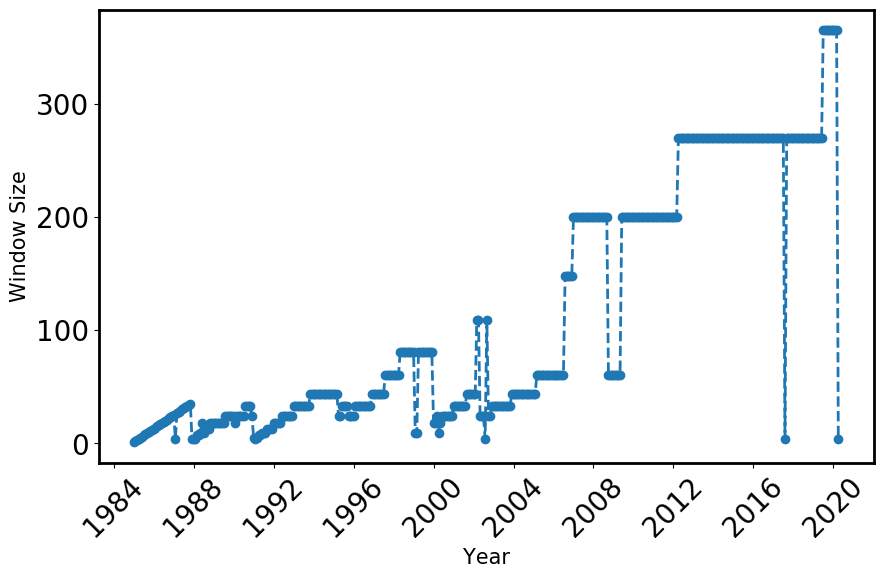

In [8]:
#Plotting the window size that is adaptively selected for each point in time

dates = [pd.to_datetime(d) for d in DT_N.Date]
plt.plot(dates,DT_N.windows, linestyle='--', marker='o')
plt.xlabel('Year')
plt.ylabel('Window Size')
plt.tick_params(axis="x", labelrotation = 45)
plt.savefig(dataset_name+'_window_size.png', transparent = True)

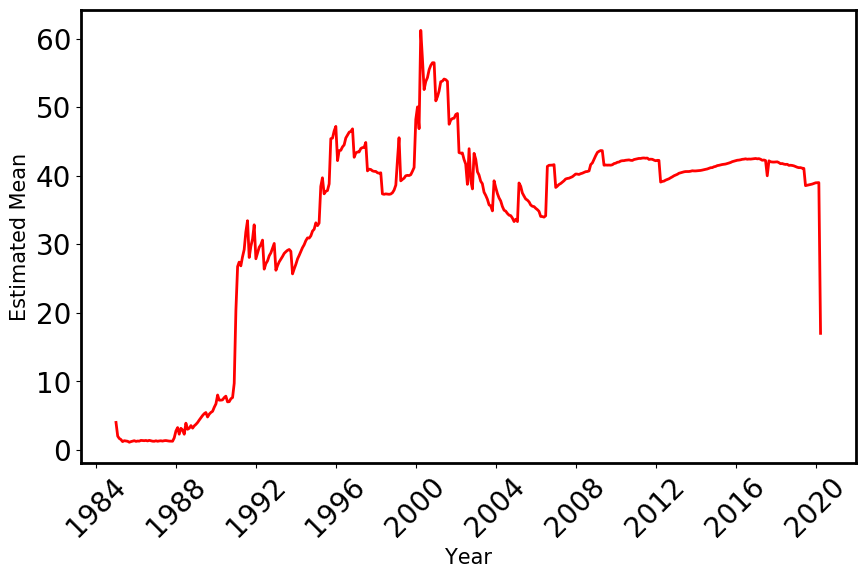

In [9]:
#Plotting the LPA estimate that is adaptively selected for each point in time

plt.plot(dates,DT_N.MLEs, linestyle='-', color = 'r')
plt.xlabel('Year')
plt.ylabel('Estimated Mean')
plt.tick_params(axis="x", labelrotation = 45)
plt.savefig(dataset_name+'_MLEs.png', transparent = True)

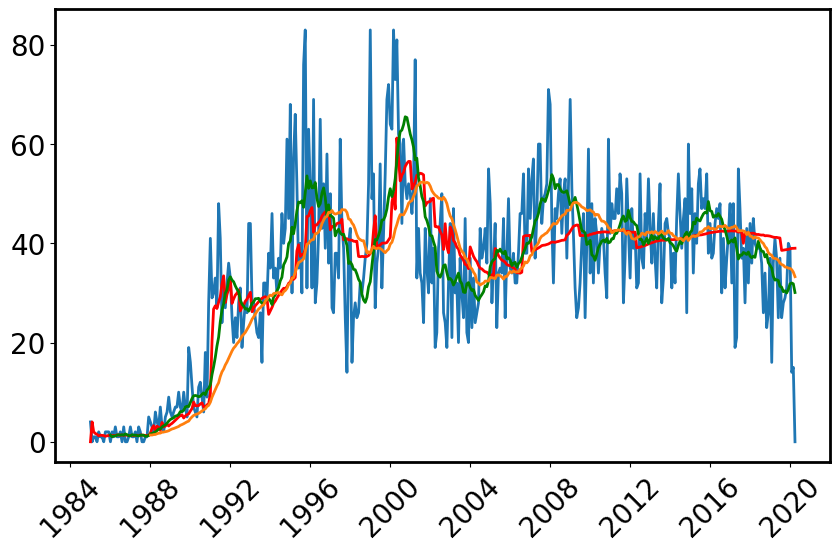

In [13]:
# Using the last LPA estimate as a prediction for the next time period and comparing it with rolling average estimates

nop=1#number of periods ahead to forecast 

#DT_N.N.plot(label='Number of M&A')
#DT_N.MLEs.plot(label='MLEs')
DT_N['forecast'] = DT_N.MLEs.shift(nop, fill_value=None)
dates = [pd.to_datetime(d) for d in DT_N.Date]
#DT_N.N.plot(label='Number of M&A',color = 'k' )
plt.plot(dates, DT_N.N)
plt.plot(dates,DT_N.forecast, linestyle='-', color = 'r')
#plt.xlabel('Year')

# Calculating moving averages using rolling window with time period 12 -we use mean because the max likelihood
# estimator of poisson is sample mean 

MovingAverage_year = DT_N.rolling(12).mean()
MovingAverage_year['forecast'] = MovingAverage_year.N.shift(nop, fill_value=None)
plt.plot(dates, MovingAverage_year.forecast, color = 'g')

max_window = 36 #the number of points after which we will calculate error because these many points have to be left behind for calculation
# Calculating moving averages
MovingAverage_3year = DT_N.rolling(max_window).mean()
MovingAverage_3year['forecast'] = MovingAverage_3year.N.shift(nop, fill_value=None)
plt.plot(dates, MovingAverage_3year.forecast)

plt.tick_params(axis="x", labelrotation = 45)
#plt.legend()

plt.savefig(dataset_name+'_comparision.png', transparent = True)

In [76]:
#Idea: Take the last point ((n+1)th from the last) as estimate and use it as prediction of next n months

n=3
MovingAverage_year = DT_N.rolling(12).mean()
MovingAverage_3year = DT_N.rolling(36).mean()

print('1-year fixed estimate is: ', MovingAverage_year.iloc[-(n+1)].N)
print('3-year fixed estimate is: ', MovingAverage_3year.iloc[-(n+1)].N)
print('LPA  estimate is: ', DT_N.iloc[-(n+1)].MLEs)

print('1-year fixed MAE is: ', sum(abs(MovingAverage_year.iloc[-(n+1)].N - DT_N.N.tail(n)))/n)
print('3-year fixed MAE is: ', sum(abs(MovingAverage_3year.iloc[-(n+1)].N - DT_N.N.tail(n)))/n)
print('LPA  MAE is: ', sum(abs(DT_N.iloc[-(n+1)].MLEs - DT_N.N.tail(n)))/n)

print('1-year fixed MSE is: ', mean_squared_error(np.repeat(MovingAverage_year.iloc[-(n+1)].N,n), DT_N.N.tail(n)))
print('3-year fixed MSE is: ', mean_squared_error(np.repeat(MovingAverage_3year.iloc[-(n+1)].N,n), DT_N.N.tail(n)))
print('LPA  MSE is: ', mean_squared_error(np.repeat(DT_N.iloc[-(n+1)].MLEs,n), DT_N.N.tail(n)))

1-year fixed estimate is:  3.0833333333333335
3-year fixed estimate is:  3.7553444180522564
LPA  estimate is:  4.23013698630137
1-year fixed MAE is:  1.75
3-year fixed MAE is:  2.422011084718923
LPA  MAE is:  2.8968036529680368
1-year fixed MSE is:  3.2847222222222228
3-year fixed MSE is:  6.088359916723557
LPA  MSE is:  8.613693626071184


In [10]:
#Calculating histogram frequencies, bins, mids)
x = DT_N.scaled_windows 
freq,bins = np.histogram(x, bins=20)
mids=(bins[1:] + bins[:-1]) / 2
rel_freq= freq/freq.sum() #relative frequency
w = mids[rel_freq.argmax()]*freq.sum() #the most occuring window size for dataset
w

98.50000000000001

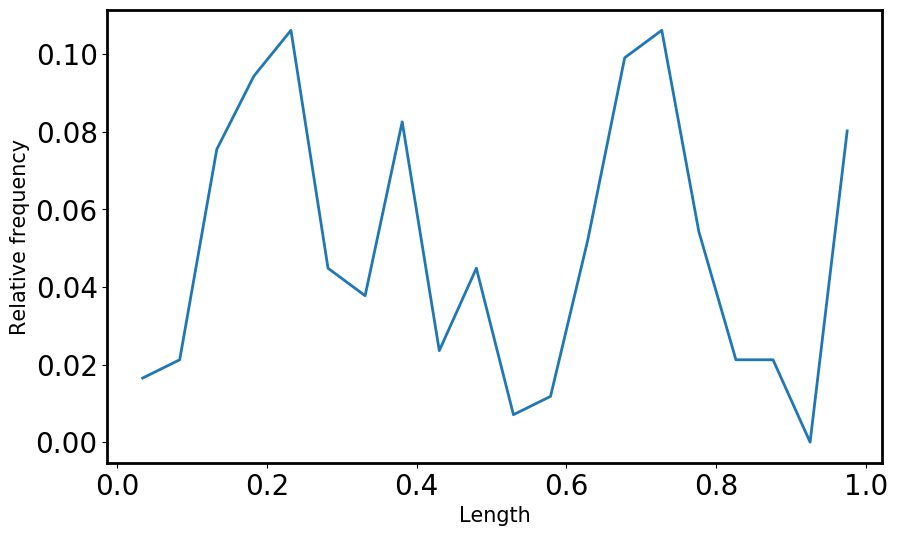

In [11]:
plt.plot(mids, rel_freq )
plt.xlabel('Length')
plt.ylabel('Relative frequency')
plt.savefig(dataset_name+'_MLE_distribution.png', transparent = True)